In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

import aesara
import aesara.tensor as at

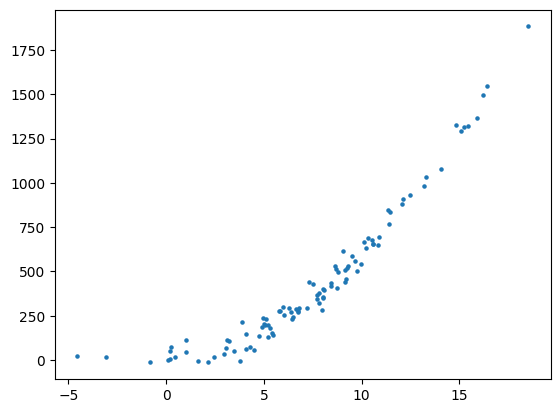

In [2]:
# 模拟数据
X = np.random.randn(100) * 5 + 7
error = np.random.randn(100) * 50
Y_obs = 5 * X ** 2 + 10 * X + error

plt.scatter(X, Y_obs, s=5)

/home/wbc/apps/anaconda3/envs/hack/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 job

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.


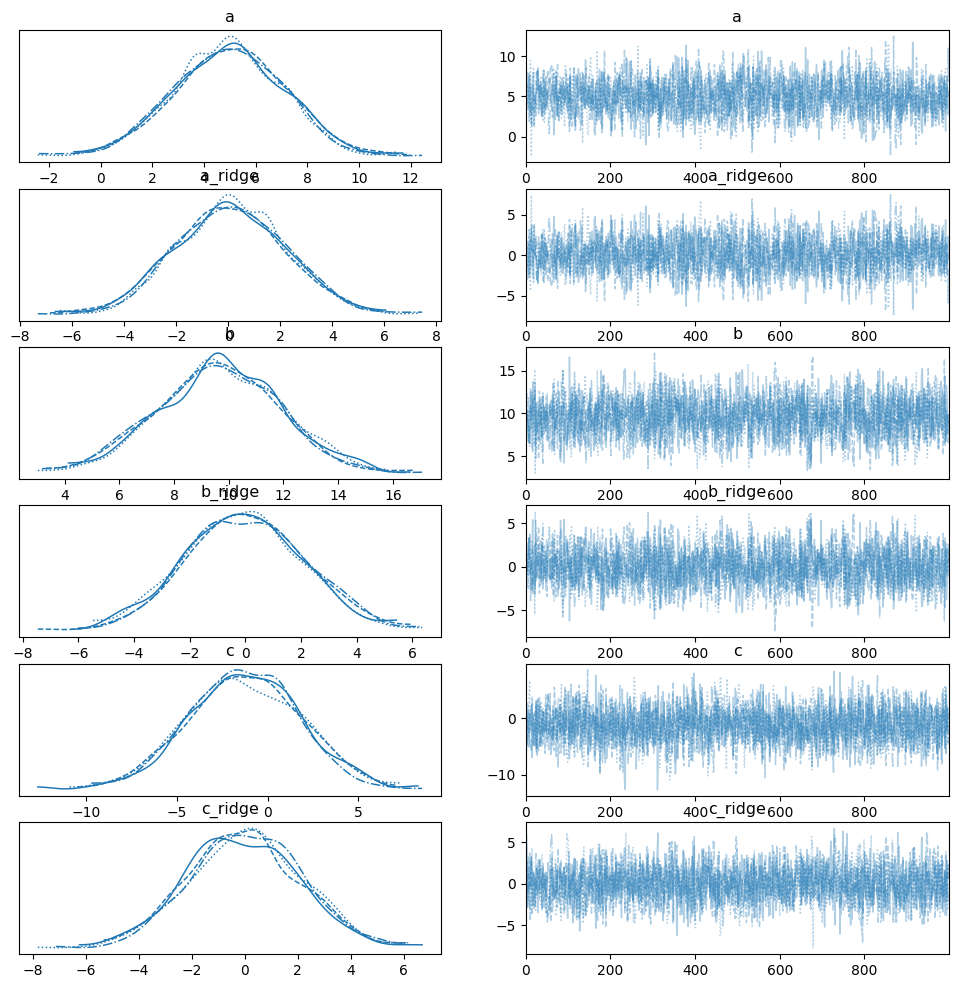

In [3]:
# Elastic Net regularization parameters
lambda_ = 0.12  # Ridge (L2) 正则化参数
alpha_ = 0.05  # Lasso (L1) 正则化参数

with pm.Model() as model_elastic_net:
    # Priors for unknown model parameters with elastic net regularization
    # a with both L1 and L2 penalties
    a = pm.Laplace('a', mu=0, b=1/(lambda_ * alpha_)) + \
        pm.Normal('a_ridge', mu=0, sigma=1/np.sqrt(2*(lambda_ * (1 - alpha_))))
    # b with both L1 and L2 penalties
    b = pm.Laplace('b', mu=0, b=1/(lambda_ * alpha_)) + \
        pm.Normal('b_ridge', mu=0, sigma=1/np.sqrt(2*(lambda_ * (1 - alpha_))))
    # c with both L1 and L2 penalties
    c = pm.Laplace('c', mu=0, b=1/(lambda_ * alpha_)) + \
        pm.Normal('c_ridge', mu=0, sigma=1/np.sqrt(2*(lambda_ * (1 - alpha_))))

    # Expected value of outcome
    mu = a * X ** 2 + b * X + c

    # Likelihood (sampling distribution) of observations
    Y = pm.Normal('Y', mu=mu, sigma=10, observed=Y_obs)

    # Sampling
    trace_elastic_net = pm.sample(1000, tune=1000, return_inferencedata=True)

# Plot the results
pm.plot_trace(trace_elastic_net)
plt.show()

In [4]:
X_test = np.linspace(np.floor(X.min()), np.ceil(X.max()), 100)

# 真值
Y_true = 5 * X_test ** 2 + 10 * X_test

# 计算后验平均值
a_posterior_mean = trace_elastic_net.posterior["a"].mean().values
b_posterior_mean = trace_elastic_net.posterior["b"].mean().values
c_posterior_mean = trace_elastic_net.posterior["c"].mean().values
Y_fit = a_posterior_mean * X_test ** 2 + b_posterior_mean * X_test + c_posterior_mean

# 计算后验标准差
a_posterior_std = trace_elastic_net.posterior["a"].std().values
b_posterior_std = trace_elastic_net.posterior["b"].std().values
c_posterior_std = trace_elastic_net.posterior["c"].std().values
Y_errorpred = a_posterior_std * X_test ** 2 + b_posterior_std * X_test + c_posterior_std

edge1 = Y_fit + Y_errorpred
edge2 = Y_fit - Y_errorpred

crosspoint = 0
for i in range(len(X_test)):
    if edge1[i] < edge2[i]:
        crosspoint = i
        break

MSE = np.mean((Y_fit - Y_true) ** 2)

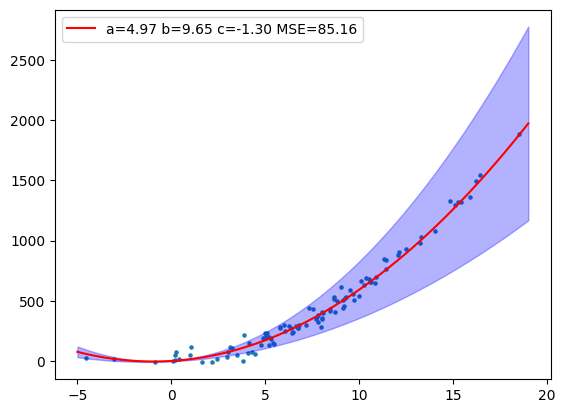

In [5]:
# 绘制填充区间
# 绘制数据点
plt.scatter(X, Y_obs, s=5)

# 绘制后验平均拟合线
plt.plot(X_test, Y_fit, color='red', label='a={:.2f} b={:.2f} c={:.2f} MSE={:.2f}'.format(
         a_posterior_mean, b_posterior_mean, c_posterior_mean, MSE))

if crosspoint:
    plt.fill_between(X_test[:crosspoint], edge2[:crosspoint], edge1[:crosspoint], color='blue', alpha=0.3, 
                     label='Uncertainty')
    plt.fill_between(X_test[crosspoint:], edge1[crosspoint:], edge2[crosspoint:], color='blue', alpha=0.3)
else:
    plt.fill_between(X_test, edge2, edge1, color='blue', alpha=0.3)

# 显示图例
plt.legend()

# 显示图表
plt.show()

#lambda=0.1,    alpha=0.05, MSE=347.40, a=4.9...,   b=9....,    c=...
#lambda=0.12,   alpha=0.05, MSE=160.80, a=5.27,     b=6.96,     c=7.08

Appendix:

Laplace分布的形式$$\text{Laplace}(\mu,b)=\frac{1}{2b}\exp \left\{-\frac{|x-\mu|}{b}\right\}$$

In [6]:
import numpy as np
import matplotlib.pyplot as plt

test = np.linspace(-10, 10, 100)
mu = 0
b = 1
Lap = 1 / (2*b) * np.exp(- abs(test - mu) / b)

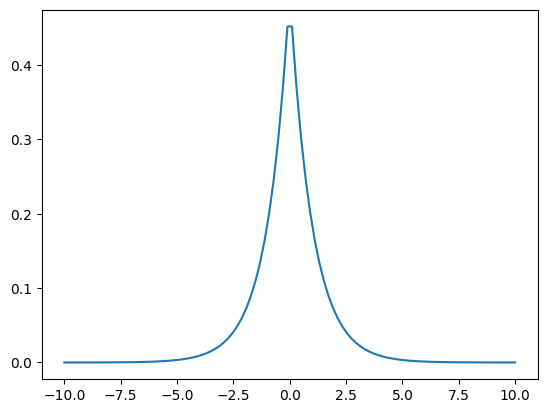

In [7]:
plt.plot(test, Lap)